# Colour processing

RGB is used to display colours for human benefit<br>
HSV are meaningful physical measures more convenient for processing<br>
https://en.wikipedia.org/wiki/HSL_and_HSV

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt   
plt.rcParams['figure.dpi'] = 100    # use to set resolution for all images

Load a colour image

In [5]:
img = cv2.imread('image/Ace.png') # img = cv2.imread('./images/r5.jpg') # 
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
print(img.shape)

(1280, 941, 3)


Let's define a function for plotting a histogram for each image component

In [4]:
def colour_histogram(image, space):
# the function gives the user the option to label the plot either RGB or HSV
# but does not convert or detect the actual format
    if space == 'rgb':
        labels = ['Blue', 'Green', 'Red']
    elif space == 'hsv':
        labels = ['Hue', 'Saturation', 'Value']
    else:
        labels = ['Component 1', 'Component 2', 'Component 3']

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for h in range(3):
        ax[h].hist(image[:,:,h].ravel(),256,[0,256])
        ax[h].set_title(labels[h])
        
    plt.show()

Plot three histograms, for each colour component: B, G, R

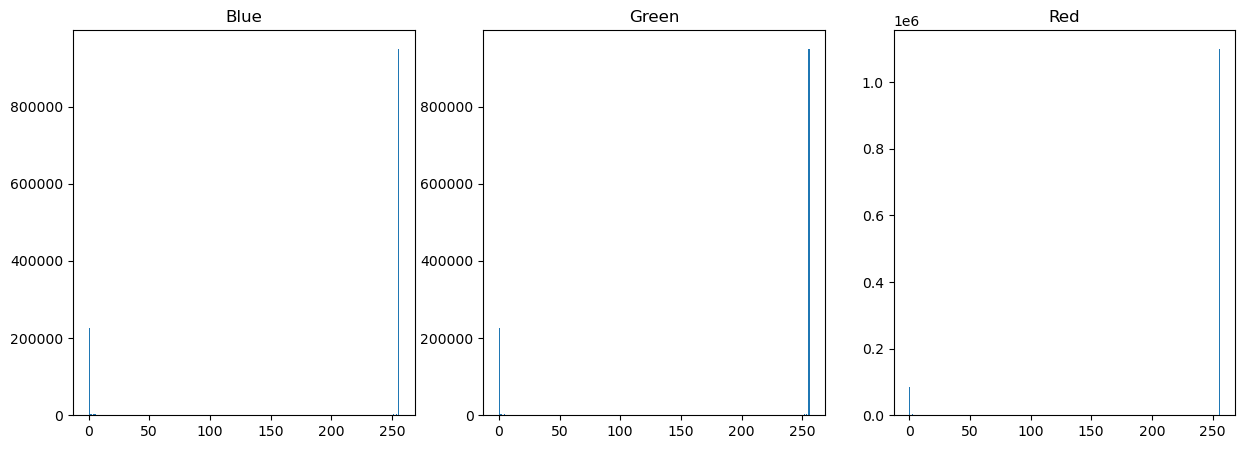

In [5]:
colour_histogram(img, 'rgb')

Plot three histograms, for each colour component: H, S, V

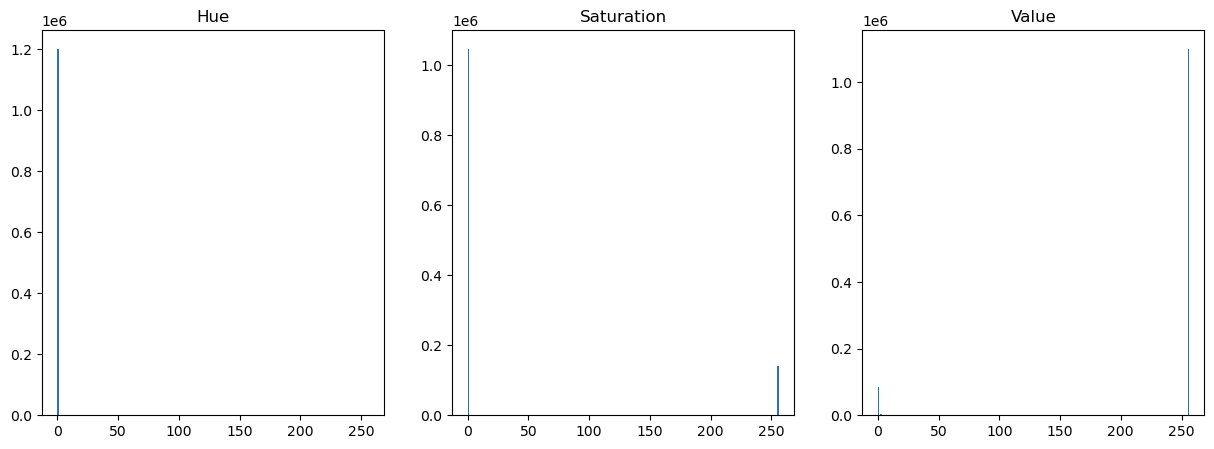

In [6]:
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV); # it is necessary to convert the image to HSV
colour_histogram(img_HSV, 'hsv')

In [7]:
# function for plotting the histogram of hue values in the corresponding colours
def hue_histogram(image):
    img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV);
    plt.figure()
    plt.xlim(0, 180)
    cm = plt.cm.get_cmap('hsv')
    n, bins, patches = plt.hist(img_HSV[:,:,0].ravel(), 256)
    for i, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(i/256))
    plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_10976\225151727.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('hsv')


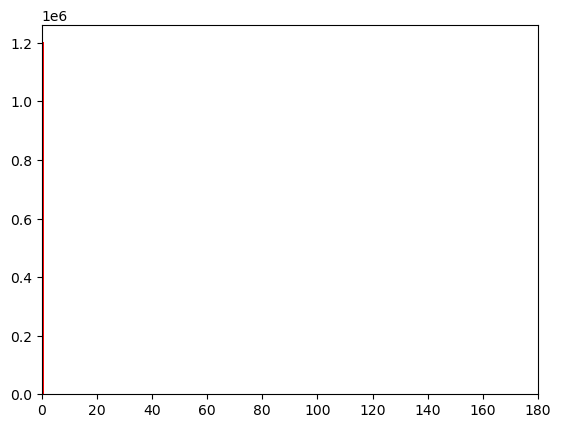

In [8]:
img = cv2.imread('Ace.png')
hue_histogram(img)

HSV seems to be a better representation for colours, but how can we identify colours using HSV space?

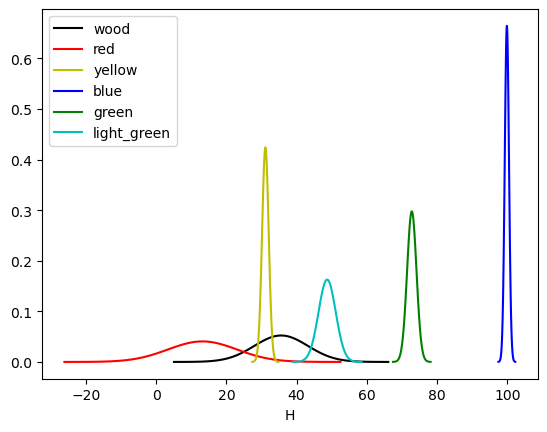

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def gauss(x, mu, sigma):
    return (2*np.pi*sigma**2)**(-.5) * np.exp(-(x-mu)**2/(2*sigma**2))

# for each colour we estimated mean and standard deviation of H, S and V values
colours = {}
colours['wood'] =        [[35.57,  37.35, 193.42], [7.63,  9.79, 13.81]] # these values will be used below
colours['red'] =         [[13.16, 127.28, 177.41], [9.83, 18.00, 32.83]]
colours['yellow'] =      [[31.09, 101.74, 208.73], [0.94, 15.65, 10.60]]
colours['blue'] =        [[99.87, 109.19, 220.15], [0.60,  9.25, 20.20]]
colours['green'] =       [[72.79, 105.61, 155.12], [1.34,  9.95, 15.63]]
colours['light_green'] = [[48.68, 110.81, 214.38], [2.45, 20.04, 19.22]]

plot_colour = {'wood':'k', 'red':'r', 'yellow':'y', 'blue':'b', 'green':'g', 'light_green':'c'}
labels = ['H', 'S', 'V']

# single channel plot of statistical distribution of each colour
channel = 0 # change value: 0, 1, 2, to plot each channel
for c in colours.keys():
    mu = colours[c][0][channel]
    sigma = colours[c][1][channel]
    min_x = mu - 4*sigma
    max_x = mu + 4*sigma
    x = np.linspace(min_x,max_x,100)
    y = gauss(x,mu,sigma)
    plt.plot(x,y,plot_colour[c])
plt.xlabel(labels[channel])
plt.legend(colours.keys())
plt.show()

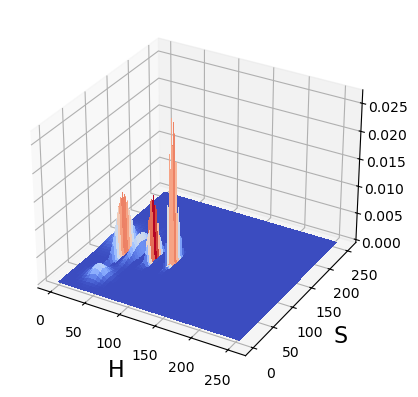

In [10]:
# double channel (3D) plot
channels = (0, 1)
fig = plt.figure()
ax = plt.axes(projection='3d')

X = np.linspace(0,255,500)
Y = np.linspace(0,255,500)
X, Y = np.meshgrid(X, Y)
Z = 0.0*X+0.0*Y

for c in colours.keys():
    x_mu = colours[c][0][channels[0]]
    x_sigma = colours[c][1][channels[0]]
    y_mu = colours[c][0][channels[1]]
    y_sigma = colours[c][1][channels[1]]
    Z += gauss(X,x_mu,x_sigma)*gauss(Y,y_mu,y_sigma)
    ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel(labels[channels[0]], fontsize = 16)
ax.set_ylabel(labels[channels[1]], fontsize = 16)
plt.show()

# Colour estimation and recognition

The first step of colour recognition is to identify the typical H, S, V values for each colour.
What sequence of operations should we execute?

For example (but find your own way):

1. identify the contour of the border of the card
2. find the top left corner, width and height with a bounding box (e.g. using cv2.boundingRect())
3. identify and select an area of the card with clear colour, relative to the bounding rectangle
4. crop the selected area
5. plot H, S, V histograms of the cropped area
6. save the values to use them during colour recognition


Once we know the values corresponding to a colour, we can apply thresholding in the HSV space.

This is done on the original image (converted to HSV), using cv2.inRange()


In [19]:
HSVredmin = np.array([0, 60, 100]) # likely minimum HSV values for red (see above)
HSVredmax = np.array([20, 255, 255]) # likely maximum HSV values for red

img = cv2.imread('test_image.jpg')
#img = cv2.resize(img, None, fx=0.25, fy=0.25)
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV);
img_col_th = cv2.inRange(img_HSV, HSVredmin, HSVredmax) # inRange selects all pixels within the desired ranges for the three channels

cv2.imshow('original',img)
cv2.imshow('colour threshold',img_col_th)
cv2.waitKey(0)
cv2.destroyAllWindows()


HSV (Hue, Saturation, Value) is often considered more convenient for certain image processing tasks compared to RGB (Red, Green, Blue) because it separates the representation of color from its intensity and allows for more intuitive manipulation of color attributes.

Here are a few reasons why HSV might be preferred over RGB for certain tasks:

#### Intuitive Color Representation: 
In HSV, the hue component represents the pure color information, saturation represents the intensity of the color, and value (or brightness) represents the brightness of the color. This separation makes it easier for humans to understand and manipulate colors intuitively. For example, adjusting the hue directly corresponds to changing the perceived color, while adjusting saturation and value allows for controlling the intensity and brightness of the color, respectively.

#### Ease of Color Manipulation: 
In many image processing tasks such as color correction, segmentation, or object detection, manipulating colors based on their characteristics like hue or saturation is more intuitive in the HSV color space. For instance, detecting objects of a certain color might be easier when hue is the primary consideration, rather than considering a combination of red, green, and blue channels in RGB.

#### Color Filtering: 
HSV often simplifies color filtering tasks. For example, if you're interested in identifying red objects in an image, you can filter based on the hue component in the HSV space, whereas in RGB, you would need to consider combinations of red, green, and blue channels, which can be more complex and less intuitive.

#### Segmentation: 
HSV can be advantageous for segmenting images into regions of different colors or for separating foreground objects from the background based on color characteristics. This is because it's easier to define color ranges in the HSV space compared to RGB.

#### Reduced Correlation: 
In the RGB color space, the three channels (red, green, blue) are correlated, which can complicate certain image processing tasks. In contrast, HSV separates the color, saturation, and brightness components, reducing this correlation and potentially simplifying analysis.

### Uno cards have four colors: red, yellow, green, blue

https://www.w3schools.com/html/html_colors_hsl.asp#:~:text=Hue%20is%20a%20degree%20on,100%25%20is%20the%20full%20color. 

In [29]:
HSVredmin = np.array([0, 60, 100]) # likely minimum HSV values for red (see above)
HSVredmax = np.array([20, 255, 255]) # likely maximum HSV values for red
HSVyellowmin = np.array([20, 60, 100]) # likely minimum HSV values for red (see above)
HSVyellowmax = np.array([40, 255, 255]) # likely maximum HSV values for red
HSVgreenmin = np.array([40, 60, 100]) # likely minimum HSV values for green (see above)
HSVgreenmax = np.array([60, 255, 255]) # likely maximum HSV values for green
HSVbluemin = np.array([100, 60, 100]) # likely minimum HSV values for blue (see above)
HSVbluemax = np.array([255, 255, 255]) # likely maximum HSV values for blue


#img = cv2.imread('test_image.jpg')
img = cv2.imread("Unocardbluereverse.png")
#img = cv2.resize(img, None, fx=0.25, fy=0.25)
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV);
img_col_th = cv2.inRange(img_HSV, HSVredmin, HSVredmax) # inRange selects all pixels within the desired ranges for the three channels
#img_col_th = cv2.inRange(img_HSV, HSVyellowmin, HSVyellowmax) # inRange selects all pixels within the desired ranges for the three channels
#img_col_th = cv2.inRange(img_HSV, HSVgreenmin, HSVgreenmax) # inRange selects all pixels within the desired ranges for the three channels
img_col_th = cv2.inRange(img_HSV, HSVbluemin, HSVbluemax) # inRange selects all pixels within the desired ranges for the three channels
print(img_col_th.sum())
cv2.imshow('original',img)
cv2.imshow('colour threshold',img_col_th)
cv2.waitKey(0)
cv2.destroyAllWindows()

36681240


In [26]:
img_col_th[400,:]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   